## Deconvolution Systems Design 

In this example we explore how the various deconvolution parameters, which we learned about in previous notebooks combine to affect deconvolution results.

Note for Mac users: There was a bug where the code for apply the 'forward' model did not default to numpy if no cupy was found.  To get the bug fix try 

```
pip uninstall tnia-python
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
```

###  Design trade-offs

1.  Iterations - more iterations provide a better result up to a point of diminishing returns.  How do we know when to stop? 
2.  PSF size - Using a larger PSF may improve deconvolution quality by increasing the spatial extent of the deblurring.  However a larger PSF size requires larger borders and larger overlap between chunks.  Note that the PSF size may be 'infinite' in thoeory (light from an emitter can propagate forever) however PSFs used for deconvolution are finite.  Thus the size of PSF used for deconvolution becomes a design parameter.
3.  Regularization - regularization can reduce noise in the output at a cost of slightly increased speed.  How do we know what regularization factor to use? 
4.  PSF - The quality of the Point Spread Function can affect final results.  If using a theoretical PSF we need to make sure the parameters used to generate the PSF match the true system parameters.
4.  Overlap - Larger overlaps will reduce artifacts, but increase processing time and memory by increasing the size of each chunk. 

### Simulation

In this example we do the following.

1.  Create a simulated image with a large sphere at the center and small spheres on the sides.  This sample is useful to study chunking artifacts because the chunks will subdivide the large sphere. 

2.  Convolve a PSF with the simulated image and add noise.  

3.  Define our deconvolution parameters including PSF parameters, dask parameters, iterations and regularization factor then deconvolve. 

### Exercise 1:  Improve the deconvolution result.  

The parameters in this notebook are sub-optimal.  First run the notebook then inspect the deconvolution result.  To improve the deconvolution try the following

1.  Inspect the PSF and make sure the forward PSF and decon PSF match, if not try adjusting the decon PSF parameters.
2.  Change the number of iterations
3.  Change the regularization factor
4.  change the overlap between chunks

### Exercise 2:  Change the parameters of the simulation

1.  Add more noise (hint Poisson noise is proportional to the number of photons, in this simulation try modifying the gain variable)
2.  Try different PSFs (for example very low NA, even greater levels of aberration)
3.  Try to create different types of phantom images, for example by drawing more spheres or different shapes.


# Imports 

In [1]:
import dask.array as da
from clij2fft.richardson_lucy import richardson_lucy_nc 
import numpy as np
import decon_helper as dh
from tnia.deconvolution.forward import forward
from tnia.plotting.projections import show_xyz_slice, show_xyz_max

tnia available
stackview available


## Create the phantom

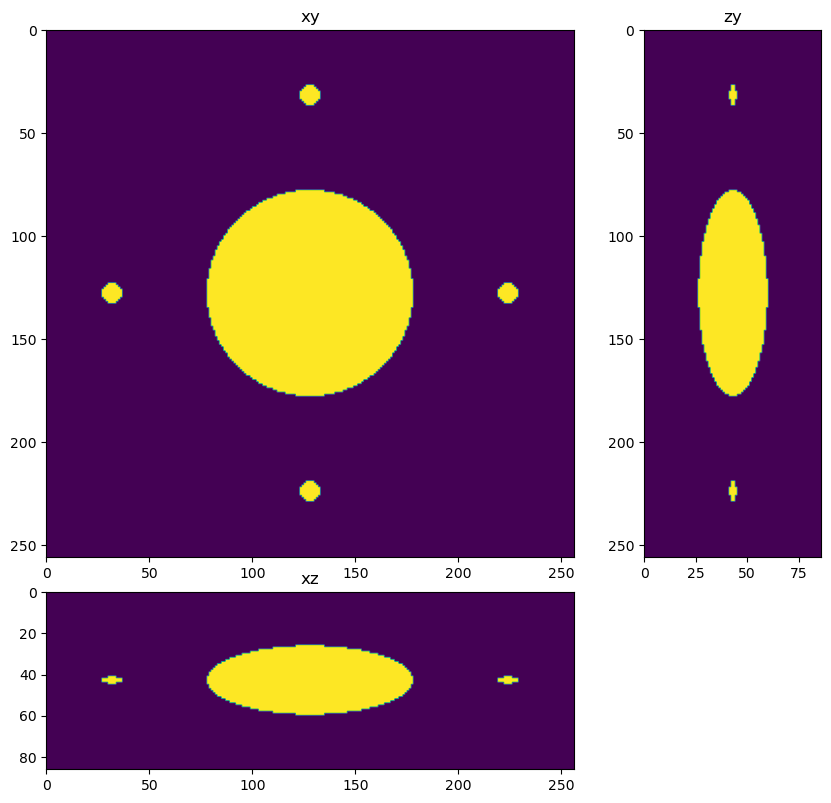

In [2]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

gain = 400
background = 0 

zdim = 256
ydim = 256
xdim = 256

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
r_small=5
size = [2*r, 2*r, 2*r]
size_small = [2*r_small, 2*r_small, 2*r_small]
sphere = rg.sphere(size, r).astype(np.float32)
small_sphere = rg.sphere(size_small, r_small).astype(np.float32)

x=100
y=100
z=50

add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, 7*phantom.shape[2]//8, phantom.shape[1]//2, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, phantom.shape[1]//8, phantom.shape[0]//2)
add_small_to_large(phantom, small_sphere, phantom.shape[2]//2, 7*phantom.shape[1]//8, phantom.shape[0]//2)

phantom = phantom[::3,:,:]
phantom = phantom*gain
dh.show_xyz_slice(phantom, 'tnia')
# set title
#fig.suptitle('Phantom with z sub-sampling=3')

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution (ie in the simulation) is different than the PSF used for deconvolution.  We can change the parameters of the deconvolution PSF to study how differences between the real PSF and the digital PSF we use for deconvolution affects the result. 

Two factors which are important but may also be only approximately known are the refractive index of the biological sample and the depth of the sample (below the cover lens).  These two factors combine to produce spherical aberration in the PSF.

If there is aberration in the true PSF of the system, to get a good deconvololution result that aberration must be matched in the sample. 

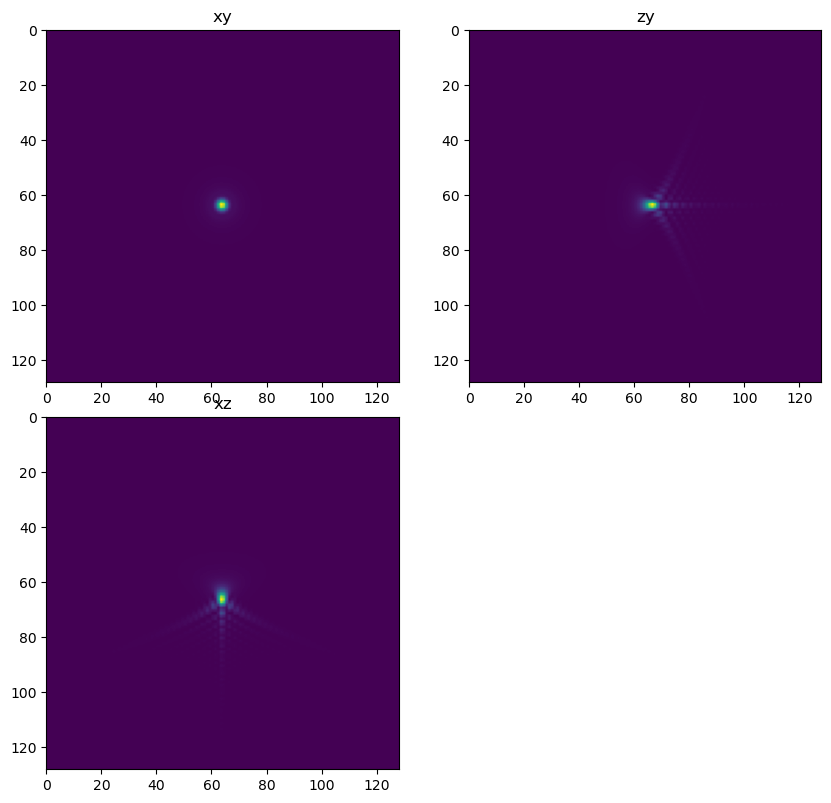

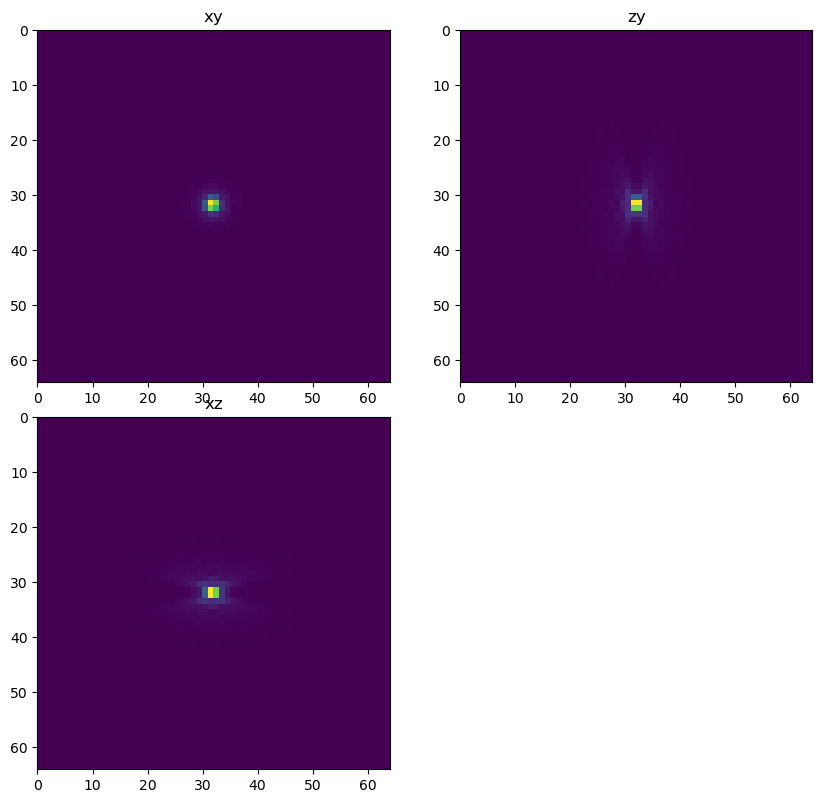

In [3]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.1
z_voxel_size=0.3

xy_psf_dim_forward=128
z_psf_dim_forward=128

xy_psf_dim_decon=64
z_psf_dim_decon=64

NA=1.4
ni=1.5
ns=1.33

# depth at which to calculate the PSF (note if there is a RI mismatch between the lens RI and sample RI spherical aberration will be introduced
# which will be depth dependent)
depth_forward = 10
depth_decon = 0 

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, depth_forward, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
psf_forward = psf_forward/psf_forward.sum()
dh.show_xyz_slice(psf_forward, 'tnia')

psf_decon  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_decon, z_psf_dim_decon, depth_decon, 0.5, False, True)
psf_decon = psf_decon.astype('float32')
psf_decon = psf_decon/psf_decon.sum()
dh.show_xyz_slice(psf_decon, 'tnia')

## Apply the forward model

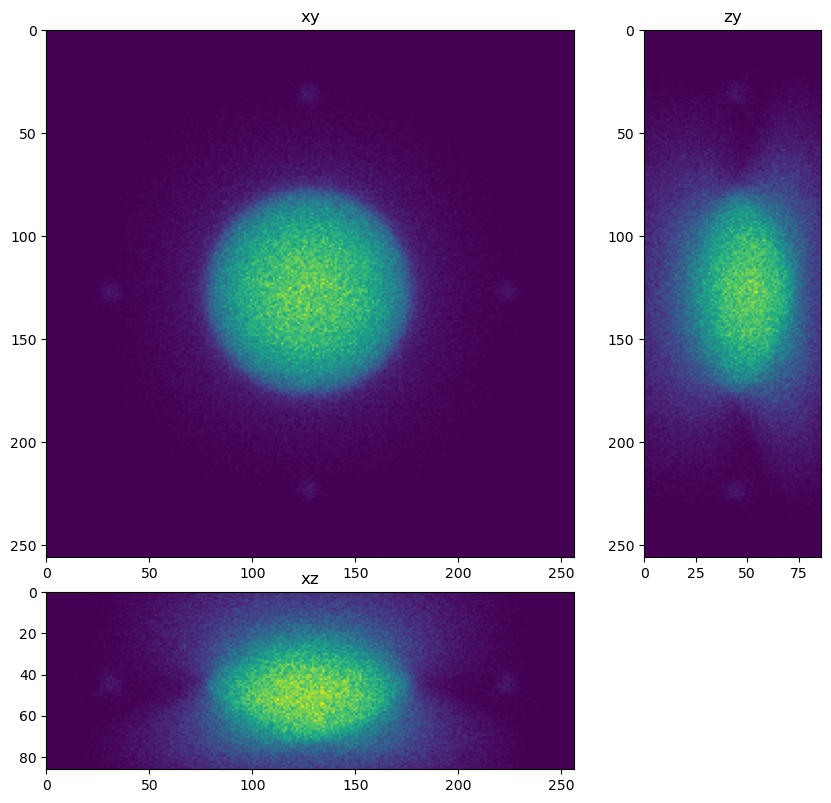

In [5]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

im = forward(phantom, psf_forward, background, True, True)

phantom=phantom+background

dh.show_xyz_slice(im, 'tnia')

## Define number of chunks

Define the number of chunks to divide the image into. 

(In this example the image is relatively small so likely the image and arrays needed for FFT based calculations would fit into the GPU without chunking, in a real life example we would pre-compute the largest chunk size we could process given memory constraints and base the chunk size on that).

In [5]:
num_x_chunks = 2 
num_y_chunks = 2
num_z_chunks = 1

z_chunk_size = im.shape[0]
y_chunk_size = int(im.shape[1]/num_x_chunks)
x_chunk_size = int(im.shape[2]/num_y_chunks)
print('chunks', z_chunk_size, y_chunk_size, x_chunk_size)


chunks 86 128 128


## Define the deconvolver

In [6]:
iterations = 200
reg = 0
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc 
    def deconv_chunk(img):
            print('deconvolving chunk with size',img.shape)
            result = richardson_lucy_nc(img, psf_decon, iterations, reg)
            print('/nfinished decon chunk')
            return result
            #return stack
    print('clij2fft non-circulant rl imported')
except ImportError:
    print('clij2fft non-circulant rl not imported')
    try:
        import RedLionfishDeconv as rl
        print('redlionfish rl imported')
        def deconv_chunk(img):
            print(img.shape,psf_decon.shape)
            result = rl.doRLDeconvolutionFromNpArrays(img, psf_decon, niter=iterations, method='gpu', resAsUint8=False )
            print('finished decon chunk')
            return result
    except ImportError:
        print('redlionfish rl not imported')



clij2fft non-circulant rl imported


## Deconvolve in chunks with overlap between chunks

Here we call the dask deconvolution using an overlap factor to prevent edge artifacts between chunks.  We try all of the clij2-fft, clij2-fft non-circulant implementation of RL and the Red Lion fish implementation. 

deconvolving chunk with size (0, 0, 0)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished/nfinished decon chunk
deconvolving chunk with size (86, 128, 128)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished/nfinished decon chunk
deconvolving chunk with size (86, 128, 128)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished/nfinished decon chunk
deconvolving chunk with size (86, 128, 128)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished/nfinished decon chunk
deconvolving chunk with size (86, 128, 128)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished/nfinished decon chunk


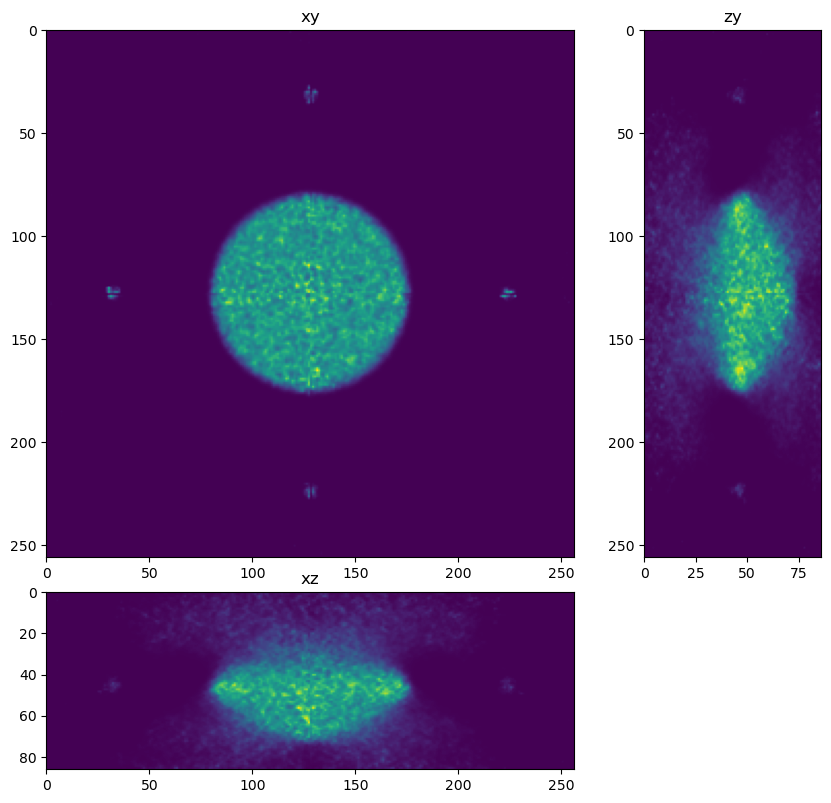

In [7]:

iterations = 100
reg = 0

overlap = 0
dimg = da.from_array(im,chunks=(z_chunk_size, y_chunk_size, x_chunk_size))

out = dimg.map_overlap(deconv_chunk, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32)
decon = out.compute(num_workers=1)

x_v = decon.shape[2]//2
y_v = decon.shape[1]//2
z_v = decon.shape[0]//2

fig = show_xyz_slice(decon, x_v, y_v, z_v)

## Visualize in Napari

In [10]:
import napari
viewer = napari.Viewer()
viewer.add_image(phantom, scale=[3,1,1],name='phantom')
viewer.add_image(im, scale=[3,1,1],name='im')
viewer.add_image(decon, scale=[3,1,1],name='decon')


<Image layer 'decon' at 0x7f98907f2f70>

2023-08-28 08:36:53.297 | INFO     | napari_assistant._gui._category_widget:call_op:178 - threshold_otsu (clesperanto)(..., )
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
4 warnings generated.
2023-08-28 08:37:23.842 | INFO     | napari_assistant._gui._category_widget:call_op:178 - threshold_otsu (clesperanto)(..., )


## Look at error

In [21]:
from tnia.metrics.errors import RMSE

print('RMSE (phantom, phantom)', RMSE(phantom, phantom))
print('RMSE (phantom, im)', RMSE(phantom, im))
print('RMSE (phantom, decon)', RMSE(phantom, decon))

RMSE (phantom, phantom) 0.0
RMSE (phantom, im) 56.637035
RMSE (phantom, decon) 50.67823
